In [1]:
import sys
!{sys.executable} -m pip install scikit-image

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import IPython.display as ipd
from environment import *

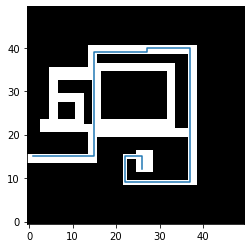

In [3]:
## Step 1: Create the world and devise robot motion
# Load in a particular environment
env = Environment("Maze1.png")
# Devise a path through that environment that passes through 3 locations
X = env.simulate_trajectory([[0, 15], [27, 40], [26, 12]])
# Plot the environment with the path superimposed
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])
 
## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
#alpha = 0.1
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 
# Create a list of scans.  Each scan holds a list of "res" laser ranges across all angles
observed_scans = [env.get_range_scan(X[i, :], res, alpha) for i in range(X.shape[0])]
state_scans = env.get_state_scans(res)

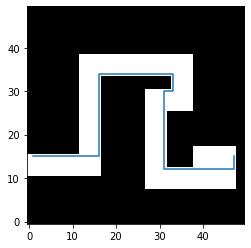

In [4]:
## Step 1: Create the world and devise robot motion
# Load in a particular environment
env = Environment("MyOwnMaze.png")
# Devise a path through that environment that passes through 3 locations
X = env.simulate_trajectory([[0, 15], [15, 15], [47, 15]])


# Plot the environment with the path superimposed
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])
 
## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
#alpha = 0.1
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 
# Create a list of scans.  Each scan holds a list of "res" laser ranges across all angles
observed_scans = [env.get_range_scan(X[i, :], res, alpha) for i in range(X.shape[0])]
state_scans = env.get_state_scans(res)

In [5]:
    def get_measurement_prob(xs, rs, alpha, gamma = 0.1):
    #def get_measurement_prob(rs, xs, alpha, gamma = 0.1):
        
        prob = 1
        
        for i in range(len(rs)):
            ri = rs[i]
            xi = xs[i]
            inside = np.log(np.sqrt(2*np.pi)*((alpha*ri)+gamma))
            sub = (xi-ri)**2 / (2*((alpha*ri)+gamma)*2)
            prob += -inside-sub
        
        return prob


In [6]:
K = len(state_scans)
T = X.shape[0]
L = np.zeros((T,K))
B = np.zeros((T,K))

for i in range(K):
    #L[1,i] = np.log(1/K) + get_measurement_prob(state_scans[i],observed_scans[0], alpha)
    L[1,i] = np.log(1/K) + get_measurement_prob(observed_scans[0], state_scans[i], alpha)
    B[1,i] = -1
for n in range(1,T):
    for k in range(K):
        maxj = -1
        maxval = -np.inf
        for j in env.neighbors[k]:
            val = L[n-1,j] + np.log(1/len(env.neighbors[j]))
            if val > maxval:
                maxj = j
                maxval = val
        #L[n,k] = get_measurement_prob(state_scans[k], observed_scans[n], alpha)
        L[n,k] = get_measurement_prob(observed_scans[n], state_scans[k], alpha) + maxval
        
        B[n,k] = maxj
        
state = np.argmax(L[-1,:]) 
states = []
n = T - 1

while n >= 0:
    states.append(state)
    state = B[n,int(state)]
    n = n - 1
    
states.reverse()                

Text(0.5, 1.0, 'Estimated Trajectory, $\\alpha=4.000$')

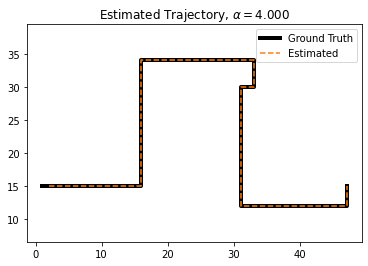

In [7]:
states = np.array(states, dtype=int)
Y = env.X[states, :]
plt.figure()
plt.plot(X[:, 0], X[:, 1], 'k', linewidth=4)
plt.plot(Y[:, 0], Y[:, 1], 'C1', linestyle='--')
plt.legend(["Ground Truth", "Estimated"])
plt.axis("equal")
plt.title("Estimated Trajectory, $\\alpha={:.3f}$".format(alpha))